<a href="https://colab.research.google.com/github/Changyoon-Lee/realization_seq2seq/blob/jeje/seq2seq(TENSOR)_mecab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 92kB 9.5MB/s 
     |████████████████████████████████| 3.8MB 37.8MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time
from google.colab import drive

drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
news_df = pd.read_excel('/content/drive/My Drive/Projects/3. seq2seq/kor.xlsx', sheet_name='Sheet1')
train_df, val_df, test_df = news_df.iloc[:50000, 1:], news_df.iloc[50000:63000, 1:], news_df.iloc[63000:, 1:]

In [6]:
!sudo apt-get install g++ openjdk-7-jdk # Install Java 1.7+
!sudo apt-get install python-dev; pip install konlpy     # Python 2.x
!sudo apt-get install python3-dev; pip3 install konlpy   # Python 3.x
!sudo apt-get install curl
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
from konlpy.tag import Mecab
mecab = Mecab()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Package openjdk-7-jdk is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'openjdk-7-jdk' has no installation candidate
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-dev is already the newest version (2.7.15~rc1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded,

In [84]:
def preprocess_sentences_eng(sentences):
    sentence = []
    for line in sentences:
        w = '<sos> '+line+' <eos>'
        sentence.append(w)
    return sentence
def preprocess_sentences_kor(sentences):
    mecab = Mecab()
    sentence = []
    for line in sentences:
        tokens = [i[0] for i in mecab.pos(line)]
        tokens.insert(0,'<eos>')
        tokens.append('<sos>')
        sentence.append(' '.join(tokens[::-1]))
    return sentence

def backprocess_sentence(sentence):
    tokens = sentence.split()
    tokens = tokens[1:-1]
    return ' '.join(tokens)

In [85]:
train_en, test_en, val_en, train_kor, test_kor, val_kor = train_df['en'], test_df['en'], val_df['en'], train_df['ko'], test_df['ko'], val_df['ko']

In [86]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='', oov_token='<UNK>')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [87]:
train_en = preprocess_sentences_eng(train_en)
train_kor = preprocess_sentences_kor(train_kor)
val_en = preprocess_sentences_eng(val_en)
val_kor = preprocess_sentences_kor(val_kor)

In [88]:
val_en[:3]

['<sos> For this summer, I have a dream to travel abroad. <eos>',
 "<sos> For example, it is touching women's sensitive post. <eos>",
 "<sos> I prefer to go on a trip by ship, because it's more fun. <eos>"]

In [89]:
#train_set 들로 tokenizer에 fit 시킨다
input_tensor_train, inp_lang = tokenize(train_kor)
target_tensor_train, targ_lang = tokenize(train_en)

In [90]:
max_length_targ, max_length_inp = target_tensor_train.shape[1], input_tensor_train.shape[1]
print('kor vocab size : {}\nen vocab size : {}'.format(len(inp_lang.word_index), len(targ_lang.word_index)))
print('kor_sentence_maxlen : {}\nen_sentence_maxlen : {}'.format(max_length_inp, max_length_targ))

kor vocab size : 17827
en vocab size : 25457
kor_sentence_maxlen : 32
en_sentence_maxlen : 19


In [91]:
def tokenize_test(sent,lang='en'):
    if lang=='ko':
        tensor = inp_lang.texts_to_sequences(sent)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen = max_length_inp,
                                                         padding='post')
        return tensor
    else :
        tensor = targ_lang.texts_to_sequences(sent)
        tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,maxlen =max_length_targ,
                                                         padding='post')
        return tensor

In [92]:
input_tensor_val = tokenize_test(val_kor, lang='ko')
target_tensor_val = tokenize_test(val_en, lang='en')

In [93]:
input_tensor_val

array([[ 2,  4, 27, ...,  0,  0,  0],
       [ 2,  4, 27, ...,  0,  0,  0],
       [ 2,  4, 27, ...,  0,  0,  0],
       ...,
       [ 2,  4, 16, ...,  0,  0,  0],
       [ 2,  4, 16, ...,  0,  0,  0],
       [ 2,  4, 16, ...,  0,  0,  0]], dtype=int32)

In [94]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))
convert(targ_lang, target_tensor_train[0])

2 ----> <sos>
4 ----> i
44 ----> go
6 ----> to
5 ----> the
12376 ----> attic
197 ----> every
1749 ----> evening
6 ----> to
128 ----> meet
12377 ----> bat.
3 ----> <eos>


In [96]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

#validation set 나누기

val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val))
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [97]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape 

(TensorShape([64, 32]), TensorShape([64, 19]))

In [98]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [99]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 32, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [100]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [101]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 32, 1)


In [102]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [103]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 25458)


In [104]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [105]:
!pip install -q pyyaml h5py

In [40]:
# checkpoint_path = "/content/drive/My Drive/Projects/3. seq2seq"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # 모델의 가중치를 저장하는 콜백 만들기
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

In [106]:
checkpoint_dir = '/gdrive/My Drive/Projects/3. seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [107]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<sos>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)
      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [108]:
def test_step(inp, targ, enc_hidden):
  loss = 0
 
  enc_out, enc_hidden = encoder(inp, enc_hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<sos>']] * BATCH_SIZE, 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
    loss += loss_function(targ[:, t], predictions)
    # storing the attention weights to plot later on
    dec_input = df.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  return batch_loss

In [109]:
from tqdm import tqdm

EPOCHS = 10

for epoch in tqdm(range(EPOCHS)):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0
  val_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  enc_hidden = encoder.initialize_hidden_state()
  for inp, targ in val_dataset.take(steps_per_epoch):
     batch_val_loss = test_step(inp, targ, enc_hidden)
     val_loss += batch_val_loss
     

  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f} val_los {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch, val_loss))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))




  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 Batch 0 Loss 5.2392
Epoch 1 Batch 100 Loss 3.3512
Epoch 1 Batch 200 Loss 3.5372
Epoch 1 Batch 300 Loss 3.0890
Epoch 1 Batch 400 Loss 3.0126
Epoch 1 Batch 500 Loss 3.0173
Epoch 1 Batch 600 Loss 2.8598
Epoch 1 Batch 700 Loss 3.0004


InvalidArgumentError: ignored

In [110]:
preprocess_sentences_kor(['왜 안되는 겁니까?'])

['<sos> ? 겁니까 는 되 안 왜 <eos>']

In [111]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentences_kor(sentence)[0]
  inputs = inp_lang.texts_to_sequences([sentence])[0]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<sos>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    if targ_lang.index_word[predicted_id] == '<eos>':
      return result, sentence, attention_plot
    result += targ_lang.index_word[predicted_id] + ' '



    # the predicted ID is fed back into the mode

    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [112]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [113]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

Input: <sos> 습니다 없 이 시간 <eos>
Predicted translation: i want to the good to the good to the good to the good to the good to the 


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45768 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50630 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_

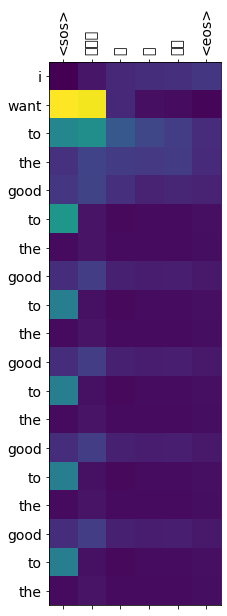

In [114]:
translate(['시간이 없습니다'])

In [115]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## BLUE SCORE

In [ ]:
!pip install --upgrade bleu
pip install --upgrade git+git://github.com/zhijing-jin/bleu.git

In [116]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
score_list = []
for i in range(len(test_kor.values[:20])):
    
    reference = [test_en.values[i].split()]
    result,_,_= evaluate([test_kor.values[i]])
    candidate = result.capitalize().split()
    score = sentence_bleu(reference, candidate, weights=(0.33,0.33,0.33))
    score_list.append(score)
    print('실제값 : {}\n예측값 : {}'.format(reference, candidate))

score = sum(score_list)/len(score_list)
print('score는 {}'.format(score))

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


실제값 : [['And', "I'm", 'here', 'to', 'explain', 'the', 'reason', 'for', 'this.']]
예측값 : ['I', 'am', 'not', 'a', 'lot', 'of', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the']
실제값 : [['I', 'want', 'to', 'say', 'about', 'the', 'cosmetic', 'sergery', 'today.']]
예측값 : ['I', 'am', 'not', 'a', 'lot', 'of', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the']
실제값 : [['We', 'would', 'like', 'to', 'renew', 'the', 'contract', 'in', 'the', 'condition', 'above.']]
예측값 : ['I', 'am', 'not', 'a', 'lot', 'of', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the']
실제값 : [['Our', 'summer', 'vacation', 'starts', 'next', 'week.']]
예측값 : ['I', 'am', 'not', 'a', 'lot', 'of', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the']
실제값 : [['She', 'is', 'an', 'interesting', 'writer', 'who', 'creates', 'new', 'things.']]
예측값 : ['I', 'am', 'not', 'a', 'lot', 'of', 

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


실제값 : [['It', 'will', 'begin', 'when', 'the', 'school', 'recommends', 'me', 'to', 'the', 'company.']]
예측값 : ['I', 'am', 'a', 'lot', 'of', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good']
실제값 : [['Since', 'tuna', 'is', 'in', 'season', 'now,', "let's", 'start', 'with', 'that.']]
예측값 : ['I', 'am', 'a', 'lot', 'of', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good']
실제값 : [['Begin', 'to', 'work,', 'not', 'thinking', 'of', 'putting', 'off', 'it.']]
예측값 : ['I', 'am', 'a', 'lot', 'of', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good']
실제값 : [['Split', 'the', 'work', 'in', 'detail', 'before', 'you', 'start.']]
예측값 : ['I', 'am', 'a', 'lot', 'of', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good']
실제값 : [['And', 'they', 'gradually', 'started', 'to', 'realize', 'the', 'truth', 'of', 'love.']]
예측값 : ['I', 

In [117]:
### smoothing ###
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
score_list = []
smoothie = SmoothingFunction().method4
for i in range(len(test_kor.values)):
    reference = [test_en.values[i].split()]
    result,_,_= evaluate([test_kor.values[i]])
    candidate = result.capitalize().split()
    score = sentence_bleu(reference, candidate, smoothing_function=smoothie)
    score_list.append(score)
    if i<20:
        print('실제값 : {}\n예측값 : {}'.format(reference, candidate))
score = sum(score_list)/len(score_list)
print('score는 {}'.format(score))

실제값 : [['And', "I'm", 'here', 'to', 'explain', 'the', 'reason', 'for', 'this.']]
예측값 : ['I', 'am', 'not', 'a', 'lot', 'of', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the']
실제값 : [['I', 'want', 'to', 'say', 'about', 'the', 'cosmetic', 'sergery', 'today.']]
예측값 : ['I', 'am', 'not', 'a', 'lot', 'of', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the']
실제값 : [['We', 'would', 'like', 'to', 'renew', 'the', 'contract', 'in', 'the', 'condition', 'above.']]
예측값 : ['I', 'am', 'not', 'a', 'lot', 'of', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the']
실제값 : [['Our', 'summer', 'vacation', 'starts', 'next', 'week.']]
예측값 : ['I', 'am', 'not', 'a', 'lot', 'of', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the', 'good', 'to', 'the']
실제값 : [['She', 'is', 'an', 'interesting', 'writer', 'who', 'creates', 'new', 'things.']]
예측값 : ['I', 'am', 'not', 'a', 'lot', 'of', 